In [43]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

In [2]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [3]:
# read in data
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)
with open('../90 Data/compiled secondary data/jpr_ampeak_baseline', 'rb') as infile:
    jpr_ampeak_baseline = pickle.load(infile)
with open('../90 Data/compiled secondary data/jpr_sectoral_ampeak_baseline', 'rb') as infile:
    jpr_sectoral_ampeak_baseline = pickle.load(infile)
with open('../90 Data/compiled secondary data/traveltimevariability', 'rb') as infile:
    traveltimevariability = pickle.load(infile)
results_coefs = pd.read_csv('../04 Reliability Data Predictive Analysis/results_lwr02_coefs.csv', index_col = 0)

In [76]:
kmeans_data = jpr_ampeak_baseline[['Targets within 45min per User']].join(jpr_sectoral_ampeak_baseline['High-End Services'][['PC Allocation From Sector']])
kmeans_data = kmeans_data.join(traveltimevariability[['Range 50PC to 95PC to Local Centroid', 'Range 50PC to 95PC to City']])
kmeans_data = kmeans_data.join(results_coefs[['dist_bus', 'dist_nationalrail', 'dist_tube', 'dist_walking']])
kmeans_data = kmeans_data.join(imd_msoa[['Index of Multiple Deprivation (IMD) Rank']])
kmeans_data_standardised = StandardScaler().fit_transform(kmeans_data)

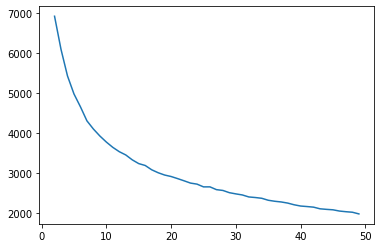

In [58]:
# identify suitable value for k
n_clusters = [i+2 for i in range(48)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [77]:
# carry out KMeans clustering
n_clusters = 8
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

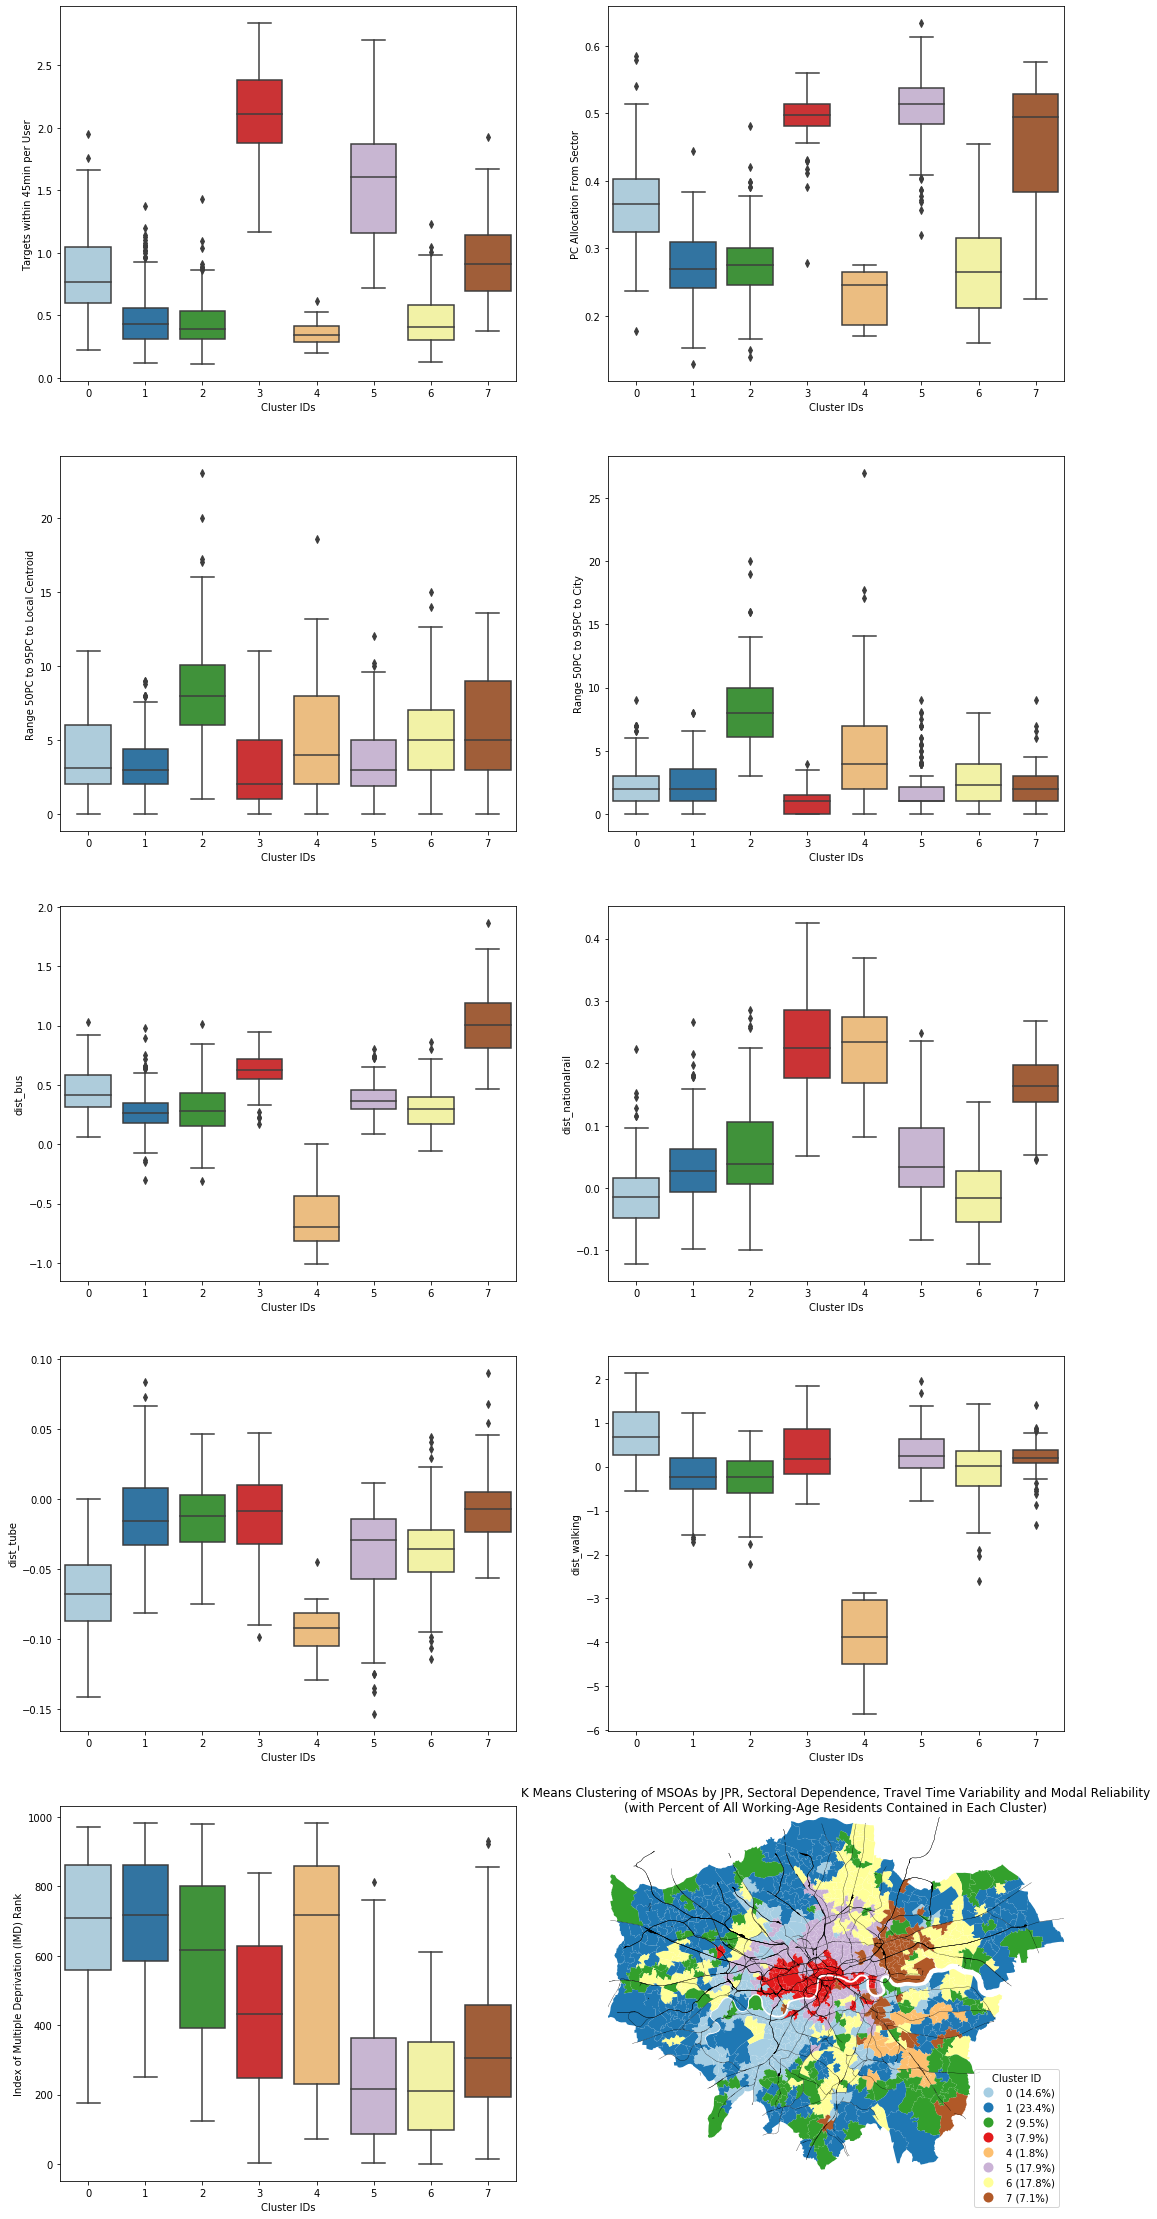

In [78]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# calculate percent working-age pop in each cluster
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
pop_per_cluster = popcounts[['Pop_WorkingAge']].join(kmeans_data['kmeans_cluster_' + str(n_clusters)])
pop_per_cluster = pop_per_cluster.groupby('kmeans_cluster_' + str(n_clusters)).sum() / popcounts['Pop_WorkingAge'].sum()

# plot data
fig01 = plt.figure(figsize = (18,40))

# boxplots
i = 1
for column in kmeans_data.columns[:-1]:
    ax01 = fig01.add_subplot(5,2,i)
    with sns.color_palette(colormap):
        ax01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = column, data = kmeans_data)
    ax01.set_xlabel('Cluster IDs')
    ax01.set_ylabel(column)
    i += 1

# clustering map
ax01_08 = fig01.add_subplot(5,2,10)
set_zoom(ax01_08, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax01_08, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_08)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_08)
legend01_08 = ax01_08.get_legend()
legend01_08.set_bbox_to_anchor((1,.3))
legend01_08.set_title('Cluster ID')
for i in range(len(legend01_08.get_texts())):
    legend01_08.get_texts()[i].set_text(str(i) + ' (' + str(round(pop_per_cluster.at[i,'Pop_WorkingAge'] * 100, 1)) + '%)')
plt.title('K Means Clustering of MSOAs by JPR, Sectoral Dependence, Travel Time Variability and Modal Reliability\n(with Percent of All Working-Age Residents Contained in Each Cluster)')
plt.axis('off')

### Analyse Clustering Stability

In [50]:
# from https://www.bonaccorso.eu/2017/08/03/assessing-clustering-optimality-instability-index/
nb_samples = kmeans_data_standardised.shape[0]
nb_features = kmeans_data_standardised.shape[1]
X = kmeans_data_standardised
print(nb_samples, nb_features)

983 9


In [62]:
# Create noisy versions
nb_noisy_versions = 20

Xp = np.ndarray(shape=(nb_noisy_versions, nb_samples, nb_features))

for i in range(nb_noisy_versions):
    for j in range(nb_samples):
#        if np.random.uniform(0, 1) < 0.5:
#            Xp[i, j, :] = X[j, :] + np.random.normal(scale=0.5, size=nb_features)
#        else:
        Xp[i, j, :] = X[j, :]
            


In [72]:
# compute instabilities
max_nb_clusters = 15
instabilities = []

for n in range(2, max_nb_clusters+1):
    Yp = []
    ds = []
    
    for k in range(nb_noisy_versions):
        km = KMeans(n_clusters=n)
        Yp.append(km.fit_predict(Xp[k, :, :]))
    
    for i in range(len(Yp)-1):
        for j in range(i, len(Yp)):
            d = pairwise_distances(Yp[i].reshape(-1, 1), Yp[j].reshape(-1, 1), 'hamming')
            ds.append(d[0, 0])
    
    instabilities.append((2.0 * np.sum(ds)) / float(nb_noisy_versions ** 2))


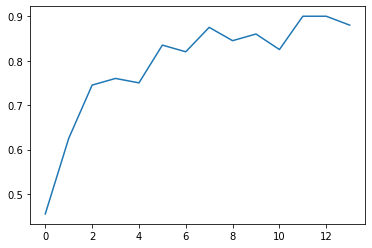

In [73]:
plt.plot(instabilities)